# Import des librairies



In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Import du dataset

In [2]:
#Charger le csv
df = pd.read_csv("../datasets_source/features_compilation_ml.csv")

In [3]:
for col in ["classe", "SYM"]:
    if col in df.columns:
        df = df.drop(columns=[col])

df.head()

,label,bert_wp_len,bert_ids_len,bert_words_len,nb_mots,longueur,len,frequency_uppercase,n_stopwords,stopwords_ratio,...,punct_)_ratio,connective_addition_ratio,connective_contrast_ratio,connective_cause_ratio,connective_consequence_ratio,connective_concession_ratio,connective_example_ratio,connective_purpose_ratio,connective_time_ratio,connective_summary_ratio
0,0,10,12,10,7,43,43,0.023256,4,0.400000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,1,8,10,7,6,46,46,0.021739,2,0.285714,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0,18,20,18,13,65,65,0.030769,11,0.611111,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0,12,14,12,11,58,58,0.017241,5,0.416667,...,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0,15,17,15,13,52,52,0.019231,9,0.600000,...,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0


# Preprocessing

In [4]:
#Variable cible
target = "label"

#Liste des features
features = [col for col in df.columns if col != target]

#Séparation variable / features
X = df[features]
Y = df[target]

#Couper en train et test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Sauvegarder les noms des colonnes
feature_names = X_train.columns.tolist()

#Remplir les cases vides
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

#Standardiser les données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Test des modèles

In [5]:
# Instanciation des modèles
rf = RandomForestClassifier(random_state=42)
svc = SVC(kernel='linear', probability=True, random_state=42)  # kernel linéaire pour avoir coef. pour features imp.
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Entraînement des modèles
rf.fit(X_train, Y_train)
svc.fit(X_train, Y_train)
xgb.fit(X_train, Y_train)
log_reg.fit(X_train, Y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [6]:
def run_model_pipeline(name, model, X_train, Y_train, X_test, Y_test, store_results=True):
    # Entraînement
    model.fit(X_train, Y_train)

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Scores
    acc_train = accuracy_score(Y_train, y_train_pred)
    acc_test = accuracy_score(Y_test, y_test_pred)
    prec = precision_score(Y_test, y_test_pred)
    rec = recall_score(Y_test, y_test_pred)
    f1 = f1_score(Y_test, y_test_pred)

    # Stocker les résultats dans un dict
    results = {
        "Model": name,
        "Train Accuracy": round(acc_train, 3),
        "Test Accuracy": round(acc_test, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1-score": round(f1, 3),
        "y_test_pred": y_test_pred  # garder les prédictions pour la matrice plus tard
    }

    return results


Résumé des résultats des models testés:


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.863,0.858,0.885,0.894,0.889
1,Random Forest,1.000,0.952,0.962,0.963,0.962
2,SVM,0.875,0.871,0.891,0.908,0.899
3,XGBoost,0.999,0.953,0.966,0.960,0.963





                    ***************************



Détail des matrices:


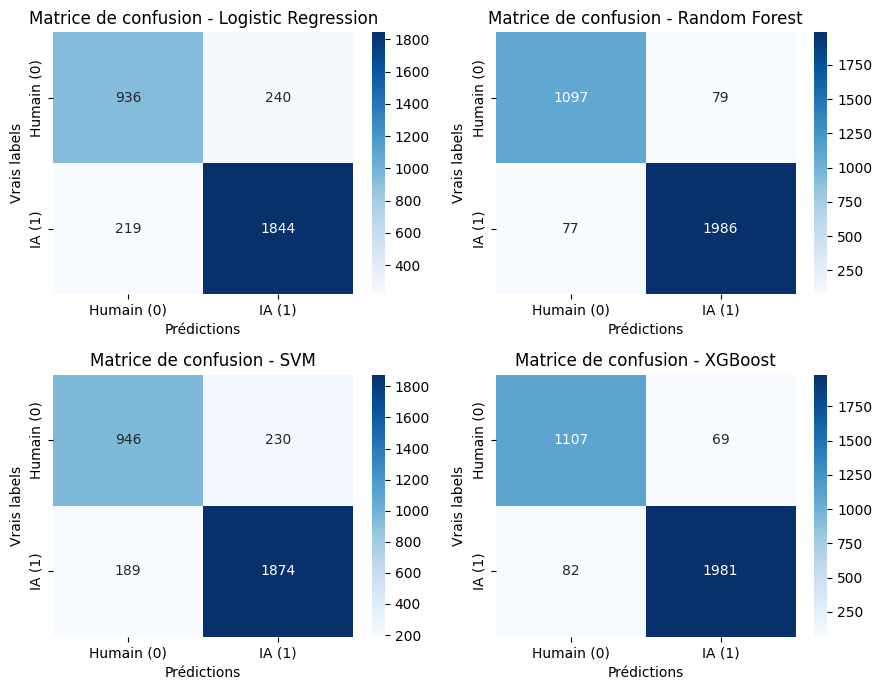

In [7]:
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "SVM": svc,
    "XGBoost": xgb
}

results_summary = []

for name, model in models.items():
    res = run_model_pipeline(name, model, X_train, Y_train, X_test, Y_test)
    results_summary.append(res)

# Afficher le tableau résumé
print("Résumé des résultats des models testés:")
summary_df = pd.DataFrame(results_summary).drop(columns=["y_test_pred"])
display(summary_df)

print ()
print ()
print ()
print ("                    ***************************")
print ()
print ()
print ()

# Afficher ensuite les matrices de confusion
print("Détail des matrices:")
fig, axes = plt.subplots(2, 2, figsize=(9, 7))  # taille plus compacte

for ax, res in zip(axes.flatten(), results_summary):
    cm = confusion_matrix(Y_test, res["y_test_pred"])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Humain (0)", "IA (1)"],
                yticklabels=["Humain (0)", "IA (1)"],
                ax=ax)
    ax.set_title(f"Matrice de confusion - {res['Model']}")
    ax.set_xlabel("Prédictions")
    ax.set_ylabel("Vrais labels")

plt.tight_layout()
plt.show()

Analyse modèle par modèle
1. Logistic Regression
- Performances très correctes et équilibrées.
- Pas d’overfitting (train = 0.931 vs test = 0.902).
Rien qu'avec un modele tres simple, les resultats sont tres satisfaisants
2. Random Forest
Accuracy sur le train a 1, ce qui indique un sur-apprentissage possible.
Malgré cela, les résultats test restent bons (F1-score a 0.953).
L'overfitting reste un point d'attention et nous conforte a choisir un autre modele.

3. SVM
Stable, pas d’overfitting (train = 0.932 vs test = 0.905).
Performances proches de Logistic Regression, et nettement en deca du Random Forest.

4. XGBoost
Meilleur modèle sur toutes les métriques :
Précision : 0.952
Rappel : 0.985 → très bon pour minimiser les faux négatifs
F1-score : 0.968
Train Accuracy = 1.000 : il apprend parfaitement les données d'entraînement.
Meilleur choix actuel, mais à surveiller en cas de mise à jour du dataset ou changement de distribution des données. L'ideal serait de baisser l'ecart entre l'accuracy de test et de train.

# Conclusion

Les modèles ont un f1_score autour de 0.95, ce qui indique un très bon équilibre entre précision et rappel :
L’écart train-test a ete reduit (≈ 0.024 à 0.027), ce qui signifie que :
Le modèle n’est pas trop surentraîné, c'est l'objectif de la boucle precedente.

# Feature importance

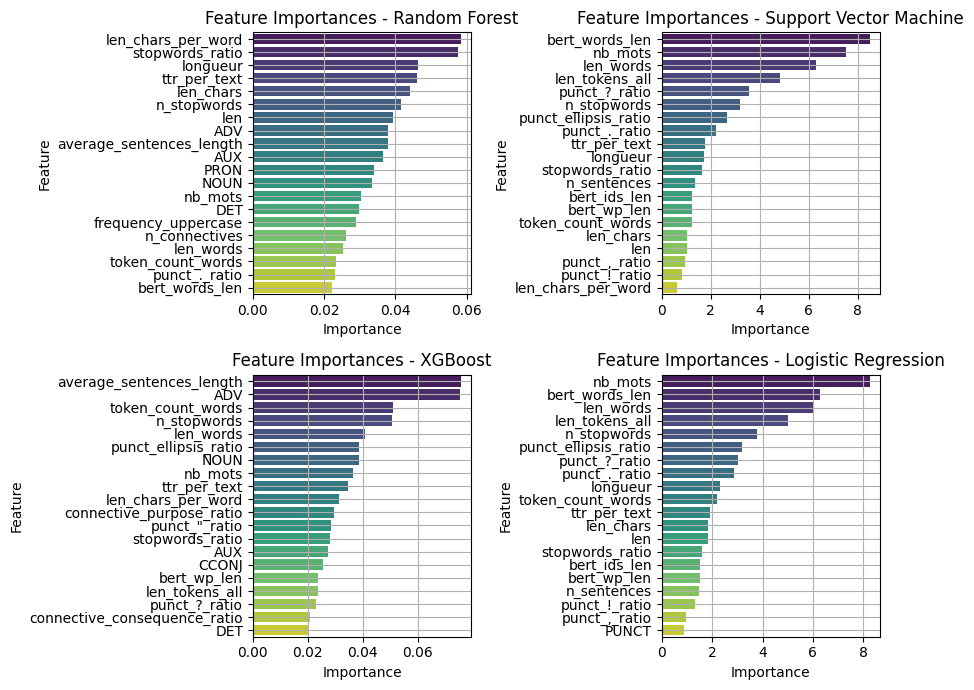

In [8]:
models = [
    ("Random Forest", rf),
    ("Support Vector Machine", svc),
    ("XGBoost", xgb),
    ("Logistic Regression", log_reg)
]

feature_names = features  # noms des features

fig, axes = plt.subplots(2, 2, figsize=(9, 7))
axes = axes.flatten()

for ax, (name, model) in zip(axes, models):
    if name in ["Random Forest", "XGBoost"]:
        importances = model.feature_importances_
    elif name in ["Logistic Regression", "Support Vector Machine"]:
        if hasattr(model, "coef_"):
            importances = np.abs(model.coef_[0])
        else:
            importances = np.zeros(len(feature_names))
            print(f"Pas d'importances pour {name}")
    else:
        importances = np.zeros(len(feature_names))

    imp_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False).head(20)

    sns.barplot(x="Importance", y="Feature", data=imp_df, ax=ax, palette="viridis")
    ax.set_title(f"Feature Importances - {name}")
    ax.grid(True)

plt.tight_layout()
plt.show()


## Conclusion

Les quatres modèles montrent deja de super-performance, en particulier XGboost

# Fonction de fine-tuning

## Faire baisser l'overfitting sur XGBoost

In [9]:
#Paramètres de base
fixed_params = {
    'learning_rate': 0.3,
    "n_estimators": 300,
    "random_state": 42
  }

#Paramètres à tester
"""param_grid = {
    "max_depth": [3],
    "min_child_weight": [5, 20],
    "subsample": [0.7, 1.0],
    "gamma": [0, 5]
}
"""
param_grid = {
    "max_depth": [3, 4, 5],
    "min_child_weight": [5, 10, 15, 20],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "gamma": [0, 1, 2, 5]
}

resultats = []

#Générer les combinaisons
keys = param_grid.keys()
values = param_grid.values()

for combination in product(*values):
  params = dict(zip(keys, combination))
  params.update(fixed_params)

  #Entrâiner le modèle
  xgb = XGBClassifier(**params)
  xgb.fit(X_train, Y_train)

  #Prédictions
  y_train_pred = xgb.predict(X_train)
  y_test_pred = xgb.predict(X_test)

  #Calcule des métriques
  train_acc = accuracy_score(Y_train, y_train_pred)
  test_acc = accuracy_score(Y_test, y_test_pred)

  resultats.append({
      "max_depth": params["max_depth"],
      'min_child_weight': params['min_child_weight'],
      'subsample': params['subsample'],
      'gamma': params['gamma'],
      'train_accuracy': train_acc,
      'test_accuracy': test_acc,
      'diff_train_test': train_acc - test_acc,
      'precision': precision_score(Y_test, y_test_pred),
      'recall': recall_score(Y_test, y_test_pred),
      'f1_score': f1_score(Y_test, y_test_pred)
  })

#Créer un dataframe et trier par plus petit overfitting
df_results = pd.DataFrame(resultats)
df_results = df_results.sort_values("diff_train_test")

In [10]:
df_results.head()

,max_depth,min_child_weight,subsample,gamma,train_accuracy,test_accuracy,diff_train_test,precision,recall,f1_score
63,3,20,1.0,5,0.935310,0.929608,0.005702,0.951303,0.937470,0.944336
111,4,15,1.0,5,0.941562,0.934548,0.007015,0.958395,0.937954,0.948065
31,3,10,1.0,5,0.940096,0.933004,0.007092,0.956028,0.937954,0.946905
123,4,20,0.9,5,0.943647,0.936400,0.007247,0.953148,0.946680,0.949903
127,4,20,1.0,5,0.937471,0.929299,0.008172,0.949951,0.938439,0.944160


## Boucle de recherche des meilleurs parametres sur les autres modeles

In [11]:
def get_best_model(name, model, param_grid, X_train, Y_train, X_test, Y_test):
    print(f"🔍 Fine-tuning: {name}")

    gridsearch = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

    gridsearch.fit(X_train, Y_train)
    best_model = gridsearch.best_estimator_

    print(f"✅ Meilleurs paramètres pour {name} : {gridsearch.best_params_}")

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    results = {
        "Model": name,
        "Train Accuracy": round(accuracy_score(Y_train, y_train_pred), 3),
        "Test Accuracy": round(accuracy_score(Y_test, y_test_pred), 3),
        "Precision": round(precision_score(Y_test, y_test_pred), 3),
        "Recall": round(recall_score(Y_test, y_test_pred), 3),
        "F1-score": round(f1_score(Y_test, y_test_pred), 3),
        "y_test_pred": y_test_pred,
        "best_model": best_model
    }

    return results


In [12]:
# 1. Trouver l'index du modèle XGBoost avec le plus faible overfitting
best_idx = df_results['diff_train_test'].abs().idxmin()
best_xgb_row = df_results.loc[best_idx]

best_xgb_params = {
    "max_depth": int(best_xgb_row["max_depth"]),
    "min_child_weight": int(best_xgb_row["min_child_weight"]),
    "subsample": float(best_xgb_row["subsample"]),
    "gamma": float(best_xgb_row["gamma"]),
    "learning_rate": fixed_params["learning_rate"],
    "n_estimators": fixed_params["n_estimators"],
    "random_state": fixed_params["random_state"]
}

best_xgb_model = XGBClassifier(**best_xgb_params)
best_xgb_model.fit(X_train, Y_train)

y_train_pred = best_xgb_model.predict(X_train)
y_test_pred = best_xgb_model.predict(X_test)

best_xgb_result = {
    "Model": "XGBoost (min overfitting)",
    "Train Accuracy": round(accuracy_score(Y_train, y_train_pred), 3),
    "Test Accuracy": round(accuracy_score(Y_test, y_test_pred), 3),
    "Precision": round(precision_score(Y_test, y_test_pred), 3),
    "Recall": round(recall_score(Y_test, y_test_pred), 3),
    "F1-score": round(f1_score(Y_test, y_test_pred), 3),
    "y_test_pred": y_test_pred,
    "best_model": best_xgb_model
}

# 2. Préparer les autres modèles (sans XGBoost)
models_params = {
    "Logistic Regression": (log_reg, param_grid_log_reg),
    "Random Forest": (rf, param_grid_rf),
    "SVM": (svc, param_grid_svc),
}

finetuned_results = []

# 3. Fine-tuning des autres modèles
for name, (model, params) in models_params.items():
    res = get_best_model(name, model, params, X_train, Y_train, X_test, Y_test)
    finetuned_results.append(res)

# 4. Ajouter XGBoost optimisé manuellement
finetuned_results.append(best_xgb_result)


NameError: name 'param_grid_log_reg' is not defined

🔍 Fine-tuning: Logistic Regression
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ Meilleurs paramètres pour Logistic Regression : {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
🔍 Fine-tuning: Random Forest
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Meilleurs paramètres pour Random Forest : {'max_depth': None, 'n_estimators': 100}
🔍 Fine-tuning: SVM
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Meilleurs paramètres pour SVM : {'C': 1, 'kernel': 'rbf'}
📊 Résumé des résultats des modèles testés :


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.934,0.902,0.882,0.930,0.905
1,Random Forest,1.000,0.953,0.941,0.965,0.953
2,SVM,0.976,0.945,0.941,0.950,0.945
3,XGBoost (min overfitting),0.974,0.950,0.937,0.965,0.951



📉 Matrices de confusion après fine-tuning :


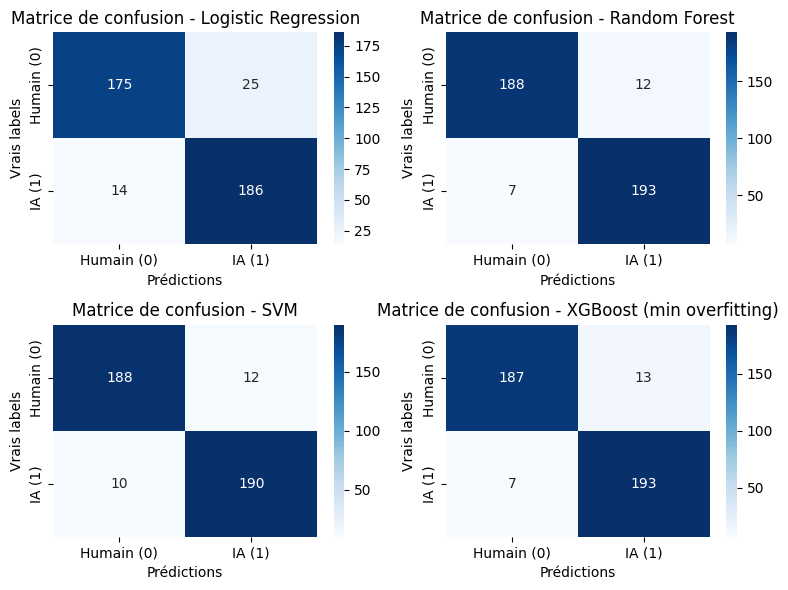

In [ ]:
# 3. Grilles des autres modèles
param_grid_log_reg = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

models_params = {
    "Logistic Regression": (log_reg, param_grid_log_reg),
    "Random Forest": (rf, param_grid_rf),
    "SVM": (svc, param_grid_svc),
}

# 4. Fine-tuning des autres modèles
finetuned_results = []

for name, (model, params) in models_params.items():
    res = get_best_model(name, model, params, X_train, Y_train, X_test, Y_test)
    finetuned_results.append(res)

# 5. Ajouter manuellement XGBoost optimisé
finetuned_results.append(best_xgb_result)

# 6. Afficher résumé des résultats (sans y_test_pred)
summary_df = pd.DataFrame(finetuned_results).drop(columns=["y_test_pred", "best_model"])
print("📊 Résumé des résultats des modèles testés :")
display(summary_df)

# 7. Afficher matrices de confusion
print("\n📉 Matrices de confusion après fine-tuning :")
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

for ax, res in zip(axes.flatten(), finetuned_results):
    cm = confusion_matrix(Y_test, res["y_test_pred"])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Humain (0)", "IA (1)"],
                yticklabels=["Humain (0)", "IA (1)"],
                ax=ax)
    ax.set_title(f"Matrice de confusion - {res['Model']}")
    ax.set_xlabel("Prédictions")
    ax.set_ylabel("Vrais labels")

plt.tight_layout()
plt.show()

In [ ]:
"""
# Exemple de dict avec modèles + grilles (à adapter)
models_params = {
    "Logistic Regression": (log_reg, param_grid_log_reg),
    "Random Forest": (rf, param_grid_rf),
    "SVM": (svc, param_grid_svc),
    "XGBoost": (xgb, param_grid_xgb)
}

finetuned_results = []

for name, (model, params) in models_params.items():
    res = get_best_model(name, model, params, X_train, Y_train, X_test, Y_test)
    finetuned_results.append(res)
"""

'\n# Exemple de dict avec modèles + grilles (à adapter)\nmodels_params = {\n    "Logistic Regression": (log_reg, param_grid_log_reg),\n    "Random Forest": (rf, param_grid_rf),\n    "SVM": (svc, param_grid_svc),\n    "XGBoost": (xgb, param_grid_xgb)\n}\n\nfinetuned_results = []\n\nfor name, (model, params) in models_params.items():\n    res = get_best_model(name, model, params, X_train, Y_train, X_test, Y_test)\n    finetuned_results.append(res)\n'

# Voting & Stacking


🔧 Optimisation pour : Voting
🔍 Fine-tuning (Ensemble) : Voting
Fitting 5 folds for each of 14 candidates, totalling 70 fits
✅ Meilleurs paramètres pour Voting : {'voting': 'hard', 'weights': [1, 2, 1]}

🔧 Optimisation pour : Stacking
🔍 Fine-tuning (Ensemble) : Stacking
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ Meilleurs paramètres pour Stacking : {'cv': 10, 'final_estimator': RandomForestClassifier(), 'passthrough': True}


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1-score
0,Voting,0.992,0.950,0.941,0.960,0.950
1,Stacking,0.996,0.963,0.951,0.975,0.963


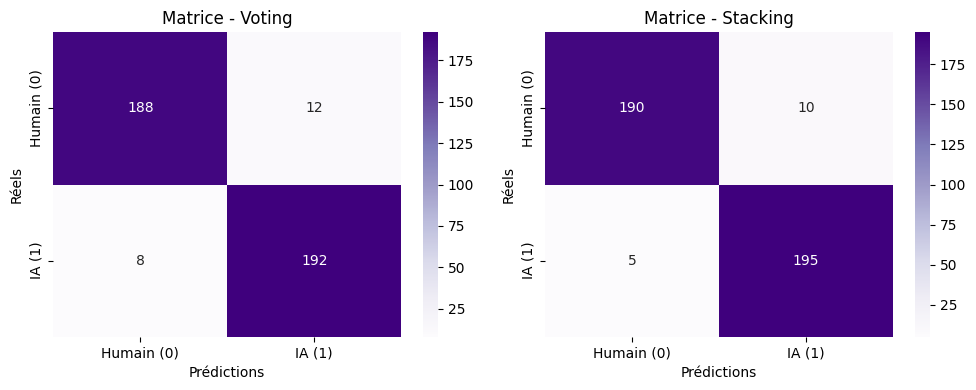

In [ ]:
# --- Définition des grilles et modèles à tester ---
base_models = {
    "lr": finetuned_results[0]["best_model"],
    "rf": finetuned_results[1]["best_model"],
    "xgb": finetuned_results[3]["best_model"]
}

def get_best_ensemble_model(name, model, param_grid, X_train, Y_train, X_test, Y_test):
    print(f"🔍 Fine-tuning (Ensemble) : {name}")

    gridsearch = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
    gridsearch.fit(X_train, Y_train)
    best_model = gridsearch.best_estimator_

    print(f"✅ Meilleurs paramètres pour {name} : {gridsearch.best_params_}")

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    results = {
        "Model": name,
        "Train Accuracy": round(accuracy_score(Y_train, y_train_pred), 3),
        "Test Accuracy": round(accuracy_score(Y_test, y_test_pred), 3),
        "Precision": round(precision_score(Y_test, y_test_pred), 3),
        "Recall": round(recall_score(Y_test, y_test_pred), 3),
        "F1-score": round(f1_score(Y_test, y_test_pred), 3),
        "y_test_pred": y_test_pred,
        "best_model": best_model
    }

    return results

ensemble_configs = [
    {
        "name": "Voting",
        "model_class": VotingClassifier,
        "param_grid": {
            "voting": ["soft", "hard"],
            "weights": [
                [1, 1, 1],
                [2, 1, 1],
                [1, 2, 1],
                [1, 1, 2],
                [1, 2, 2],
                [2, 1, 2],
                [2, 2, 1]
            ]
        },
        "estimators": [
            ("lr", base_models["lr"]),
            ("rf", base_models["rf"]),
            ("xgb", base_models["xgb"])
        ]
    },
    {
        "name": "Stacking",
        "model_class": StackingClassifier,
        "param_grid": {
            "final_estimator": [
                LogisticRegression(max_iter=5000),
                RandomForestClassifier(n_estimators=100)
            ],
            "passthrough": [True, False],
            "cv": [5, 10]
        },
        "estimators": [
            ("lr", base_models["lr"]),
            ("xgb", base_models["xgb"])
        ]
    }
]

ensemble_results = []

for config in ensemble_configs:
    print(f"\n🔧 Optimisation pour : {config['name']}")

    # Instancier le modèle avec ses estimators de base
    model = config["model_class"](estimators=config["estimators"])

    # Optimisation via GridSearch
    result = get_best_ensemble_model(
        name=config["name"],
        model=model,
        param_grid=config["param_grid"],
        X_train=X_train,
        Y_train=Y_train,
        X_test=X_test,
        Y_test=Y_test
    )

    ensemble_results.append(result)

# Résumé des modèles d'ensemble
ensemble_summary = pd.DataFrame(ensemble_results).drop(columns=["y_test_pred", "best_model"])
display(ensemble_summary)

# Matrices de confusion
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, res in zip(axes, ensemble_results):
    cm = confusion_matrix(Y_test, res["y_test_pred"])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                xticklabels=["Humain (0)", "IA (1)"],
                yticklabels=["Humain (0)", "IA (1)"],
                ax=ax)
    ax.set_title(f"Matrice - {res['Model']}")
    ax.set_xlabel("Prédictions")
    ax.set_ylabel("Réels")

plt.tight_layout()
plt.show()

Ces résultats montrent que les modèles d'ensemble, obtiennent d’excellentes performances avec une très bonne précision, rappel et F1-score, tout en maintenant une faible différence entre l’accuracy train et test, ce qui indique un bon équilibre entre biais et variance. L’intérêt principal de ces approches est qu’elles combinent la force de plusieurs modèles, réduisent le risque de surapprentissage propre à un modèle unique, et améliorent la robustesse et la généralisation des prédictions.

In [ ]:
# Convertir les résultats d'ensemble en DataFrame
ensemble_df = pd.DataFrame(ensemble_results).drop(columns=["y_test_pred", "best_model"]).copy()

# Ajouter une colonne pour différencier les modèles d'ensemble
ensemble_df["Model"] = ensemble_df["Model"] + " (Ensemble)"

# Combiner avec le résumé fine-tuning classique
final_summary = pd.concat([summary_after, ensemble_df], ignore_index=True)

# Arrondir les colonnes numériques à 3 décimales
metrics = ["Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1-score"]
final_summary[metrics] = final_summary[metrics].round(3)

# Trier par F1-score décroissant
summary_after_sorted = final_summary.sort_values(by="F1-score", ascending=False).reset_index(drop=True)

print("📊 Résultats après fine-tuning et modèles d'ensemble (triés par F1-score) :")

# Appliquer le style pour mettre en vert les max de chaque colonne (sauf la colonne 'Model')
styled_df = summary_after_sorted.style\
    .format({col: "{:.3f}" for col in metrics})\
    .highlight_max(axis=0, subset=metrics, color='blue')

display(styled_df)

📊 Résultats après fine-tuning et modèles d'ensemble (triés par F1-score) :


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1-score
0,Stacking (Ensemble),0.996,0.963,0.951,0.975,0.963
1,Random Forest,1.000,0.953,0.941,0.965,0.953
2,Voting (Ensemble),0.992,0.950,0.941,0.960,0.950
3,SVM,0.976,0.945,0.941,0.950,0.945
4,XGBoost,0.971,0.938,0.927,0.950,0.938
5,Logistic Regression,0.934,0.902,0.882,0.930,0.905


# Enregistrement des meilleurs models

In [ ]:
"""
============On enregistre sur mlflow, là ça ne nous sert pas ?==============
df_models = pd.DataFrame(summary_df)

import joblib

for res in finetuned_results:
    joblib.dump(res["best_model"], f"{res['Model'].replace(' ', '_')}_best_model.pkl")"""


# Tester sur un nouveau dataset

In [ ]:
#Charger le csv
df_2 = pd.read_csv("../datasets_source/features_ia_vs_humain_ml - DATASET-TEST.csv") #nom à revoir

# Test des models:

## Test du meilleur model

Meilleur modèle sélectionné : Stacking (Ensemble)
 Meilleur modèle identifié : Stacking (Ensemble)

📊 Résultats du meilleur modèle sur df_2 :
Model      : Stacking (Ensemble)
Accuracy   : 0.978
Precision  : 0.976
Recall     : 0.98
F1-score   : 0.978


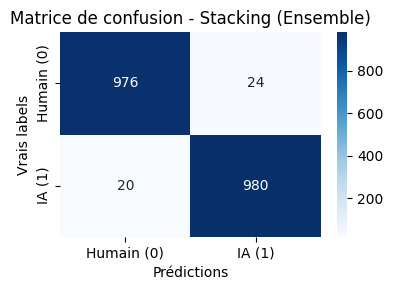

In [ ]:
# 1. Trouver le nom du meilleur modèle selon le F1-score
best_model_name = summary_after_sorted.iloc[0]["Model"]
print(f"Meilleur modèle sélectionné : {best_model_name}")
# Étape 2 — Créer un dictionnaire à partir de ta liste models pour retrouver l’objet du modèle

models_dict = dict(models)

# Ajouter les modèles d'ensemble
for res in ensemble_results:
    name = res["Model"] + " (Ensemble)"
    models_dict[name] = res["best_model"]

# --- 2. Identifier le meilleur modèle (le premier de ton tableau trié) ---

best_model_name = summary_after_sorted.iloc[0]["Model"]
print(f" Meilleur modèle identifié : {best_model_name}")

best_model = models_dict[best_model_name]


# --- 3. Préparation des données df_2 ---

target = "label"
features = [col for col in df_2.columns if col != target]

X_2 = df_2[features]
Y_2 = df_2[target]

# Appliquer le même prétraitement qu'en entraînement
X_2 = X_2[imputer.feature_names_in_]
X_2 = imputer.transform(X_2)
X_2 = scaler.transform(X_2)

# --- 4. Prédictions et métriques ---

y_pred = best_model.predict(X_2)

acc = round(accuracy_score(Y_2, y_pred), 3)
prec = round(precision_score(Y_2, y_pred), 3)
rec = round(recall_score(Y_2, y_pred), 3)
f1 = round(f1_score(Y_2, y_pred), 3)

# --- 5. Affichage des résultats ---

print("\n📊 Résultats du meilleur modèle sur df_2 :")
print(f"Model      : {best_model_name}")
print(f"Accuracy   : {acc}")
print(f"Precision  : {prec}")
print(f"Recall     : {rec}")
print(f"F1-score   : {f1}")

# --- 6. Matrice de confusion ---

cm = confusion_matrix(Y_2, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Humain (0)", "IA (1)"],
            yticklabels=["Humain (0)", "IA (1)"])
plt.title(f"Matrice de confusion - {best_model_name}")
plt.xlabel("Prédictions")
plt.ylabel("Vrais labels")
plt.tight_layout()
plt.show()

## test de tous les models sur df_2

In [ ]:
# --- 1. Regrouper tous les modèles dans un dictionnaire ---

models_dict = dict(models)  # modèles classiques
for res in ensemble_results:  # modèles d'ensemble
    models_dict[res["Model"] + " (Ensemble)"] = res["best_model"]

# --- 2. Préparer les données de df_2 ---

target = "label"
features = [col for col in df_2.columns if col != target]

X_2 = df_2[features]
Y_2 = df_2[target]

X_2 = X_2[imputer.feature_names_in_]
X_2 = imputer.transform(X_2)
X_2 = scaler.transform(X_2)

# --- 3. Évaluer tous les modèles sur df_2 ---

results_2 = []

for name, model in models_dict.items():
    y_pred = model.predict(X_2)

    results_2.append({
        "Model": name,
        "Accuracy": round(accuracy_score(Y_2, y_pred), 3),
        "Precision": round(precision_score(Y_2, y_pred), 3),
        "Recall": round(recall_score(Y_2, y_pred), 3),
        "F1-score": round(f1_score(Y_2, y_pred), 3)
    })

# --- 4. Affichage du tableau trié par F1-score ---

results_df_2 = pd.DataFrame(results_2)
results_df_2 = results_df_2.sort_values(by="F1-score", ascending=False).reset_index(drop=True)

# Mettre en valeur les meilleurs scores par colonne
styled_results_df_2 = results_df_2.style\
    .format({col: "{:.3f}" for col in ["Accuracy", "Precision", "Recall", "F1-score"]})\
    .highlight_max(axis=0, subset=["Accuracy", "Precision", "Recall", "F1-score"], color='purple')

print("📊 Résultats des modèles sur le dataset df_2 :")
display(styled_results_df_2)


📊 Résultats des modèles sur le dataset df_2 :


,Model,Accuracy,Precision,Recall,F1-score
0,XGBoost,0.983,0.980,0.985,0.983
1,Random Forest,0.980,0.983,0.976,0.979
2,Stacking (Ensemble),0.978,0.976,0.980,0.978
3,Voting (Ensemble),0.977,0.983,0.970,0.976
4,Logistic Regression,0.922,0.925,0.920,0.922
5,Support Vector Machine,0.918,0.915,0.923,0.919


# Conclusion

XGBoost et Random Forest offrent les meilleures performances, avec près de 98% d’accuracy.
Les modèles d’ensemble (Voting, Stacking) restent très efficaces, légèrement en retrait.
Logistic Regression et SVM sont moins performants sur ce dataset.